# Scalable Question Generation System

#### High Level Design of the System

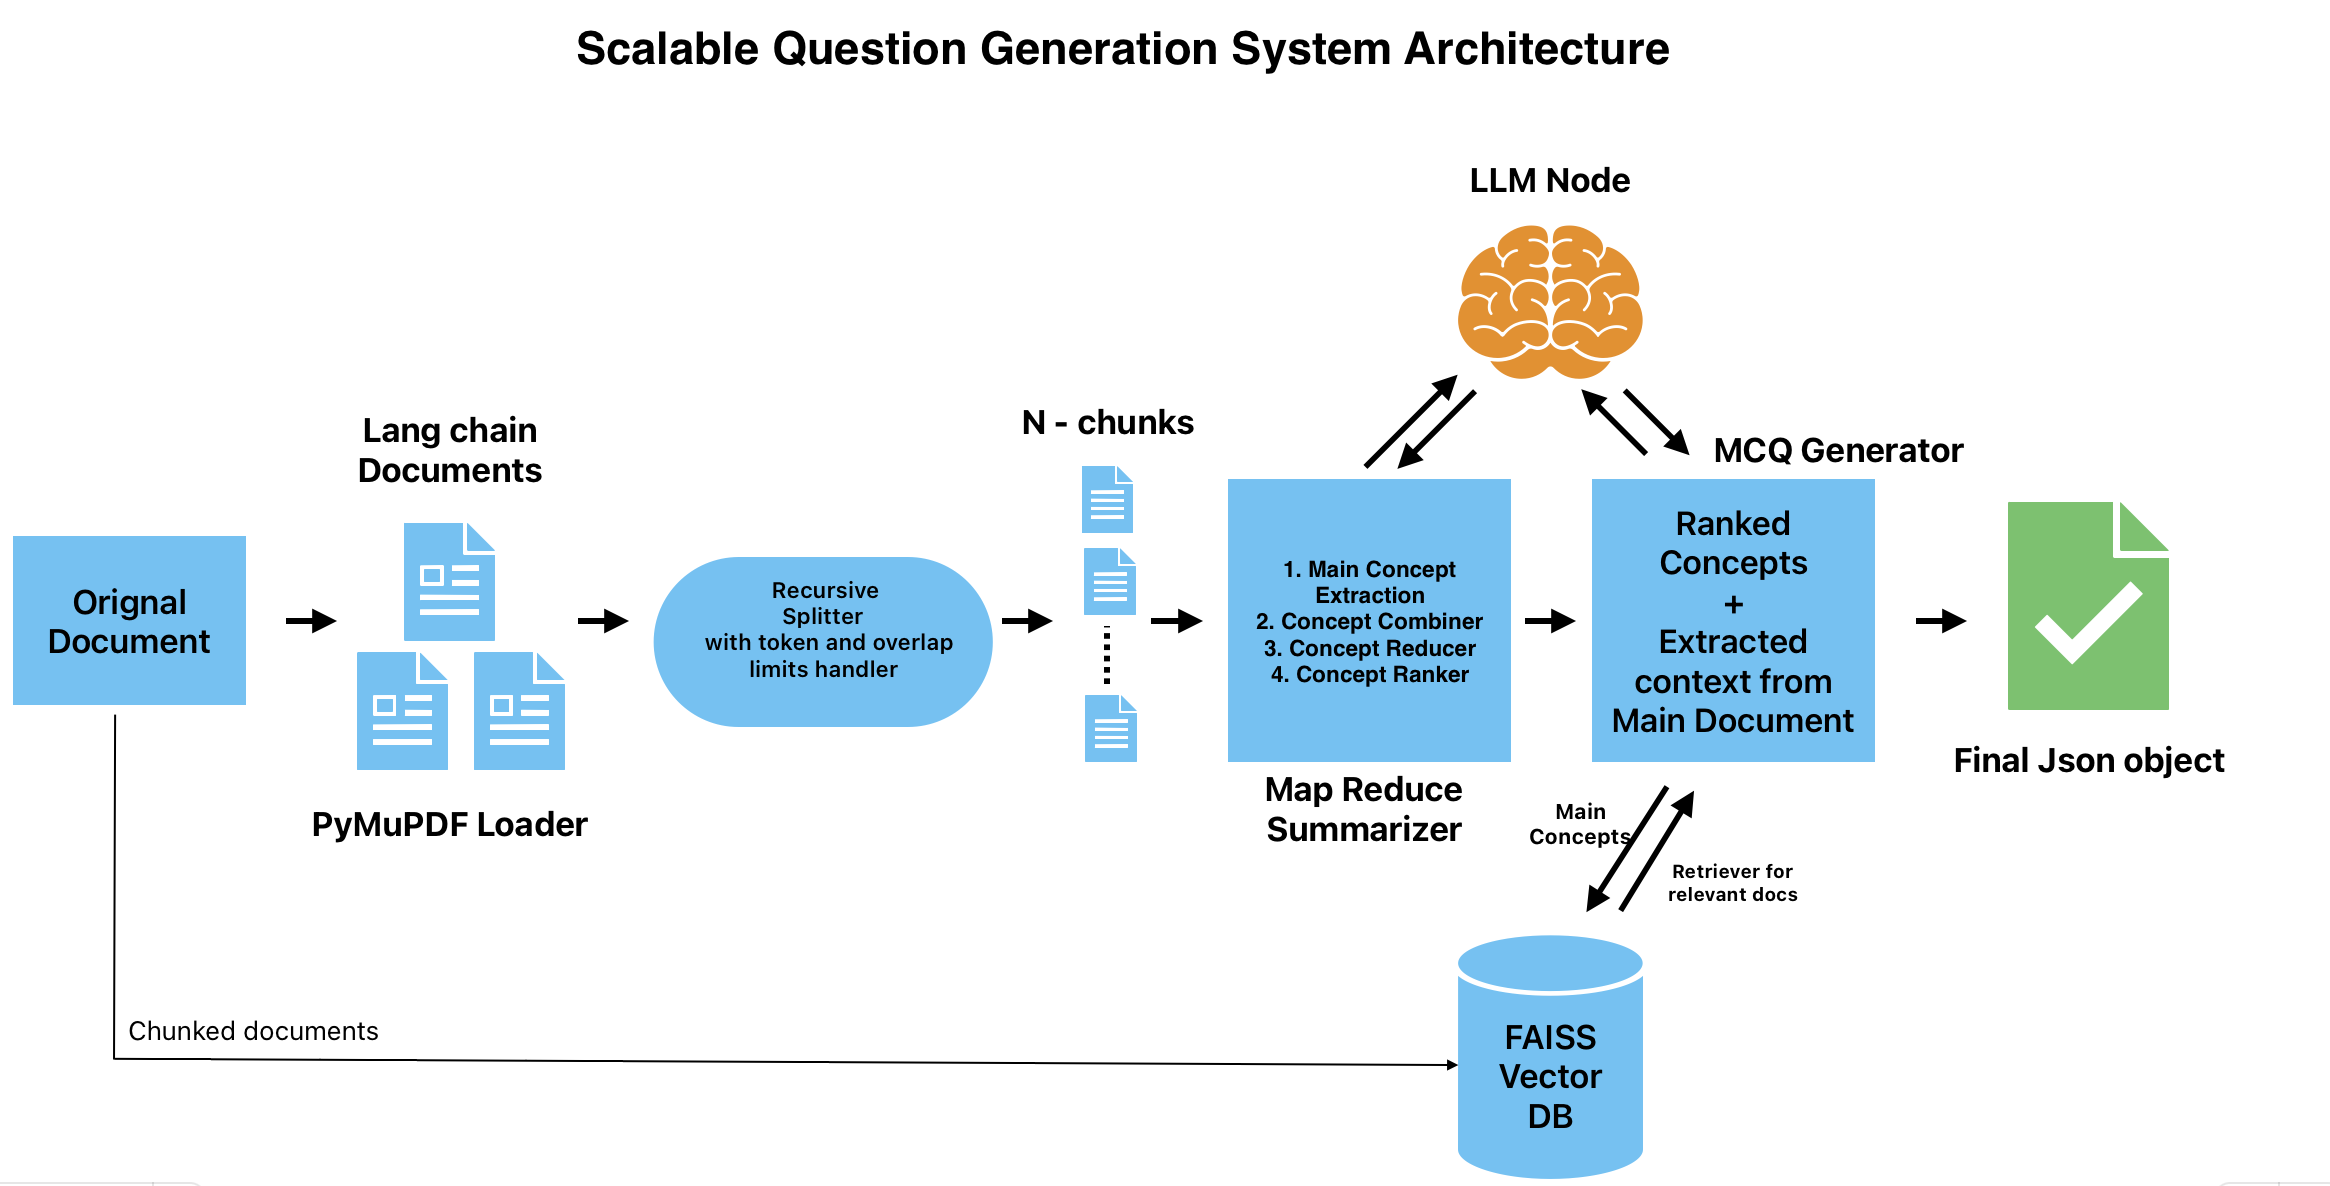

#### Tools and Requirements 


##### Tools :  
- **Language:** Python  
- **LLM API:** Gemini API (or OpenAI / Anthropic)    (I used gemini-1.5-flash LLM)

##### Requirements :  
1. langchain  
2. langchain-community  
3. pymupdf 
4. google-generativeai  
5. python-dotenv  
6. tiktoken  
7. faiss-cpu  
8. sentence-transformers  

#### LLM Node  

This module defines the **LLMInvoke** class, a wrapper around the Gemini API.  
It provides a simple interface to send prompts and retrieve responses, making the LLM callable in required areas of the project.  


In [4]:
# imports
import google.generativeai as genai
from dotenv import load_dotenv
import os
load_dotenv()
api_key = os.getenv("GEMINI_API_KEY") #  Give your Gemini API KEY
genai.configure(api_key=api_key)

# print(api_key)


In [5]:
# This class handles invoking a Generative AI model and fetching responses.
class LLMInvoke:
    def __init__(self, model_name="gemini-1.5-flash"):
        self.model_name = model_name
        self.model = genai.GenerativeModel(model_name=self.model_name)

    def llm_response(self, prompt, context=None):
        """
        Generates a response from the model for a given prompt.
        Returns a dictionary with the answer or an error message.
        """
        try:
            response = self.model.generate_content(prompt)
            return {"answer": response.text}
        except Exception as e:
            return {"answer": f"Error processing query: {str(e)}"}


# Example usage
if __name__ == "__main__":
    llm_invoke = LLMInvoke()
    example_query = "LLM Quantization means?"
    result = llm_invoke.llm_response(example_query)
    print(result)


E0000 00:00:1758582456.746917  458464 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


{'answer': "LLM quantization is a technique used to reduce the size and computational requirements of large language models (LLMs) without significantly sacrificing performance.  It does this by reducing the precision of the numbers (weights and activations) used within the model.  Instead of using 32-bit floating-point numbers (FP32), which are standard in many LLMs, quantization reduces the precision to lower bit representations, such as:\n\n* **INT8 (8-bit integers):**  This is a common choice, offering a significant reduction in size and computational cost.\n* **INT4 (4-bit integers):** Offers even greater compression and speedup, but may result in a larger performance drop.\n* **Binary (1-bit):**  Extreme compression, but with potentially the largest performance degradation.\n\nThe process involves mapping the original floating-point values to their quantized integer counterparts.  There are several quantization methods, each with trade-offs between accuracy and compression:\n\n* 

#### File Processor
This script defines a `FileProcessor` class that detects file types (PDF, Word, TXT) and loads them into `LangChain` documents.  
It supports both single files and directories, with multiprocessing for faster batch processing.  


In [6]:
import os
from typing import List
from langchain.schema import Document
from langchain_community.document_loaders import (
    PyMuPDFLoader,
    UnstructuredWordDocumentLoader,
    TextLoader
)
import multiprocessing

class FileProcessor:
    """
    FileProcessor handles loading documents from different file types (.pdf, .docx, .txt),
    supports directory traversal, and can process files in parallel using multiprocessing.
    """

    def check_type(self, file_path: str) -> List[Document]:
        """Detects file type and loads documents using the appropriate loader."""
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")

        file_extension = os.path.splitext(file_path)[1].lower()

        if file_extension == ".pdf":
            loader = PyMuPDFLoader(file_path)
        elif file_extension in {".docx", ".doc"}:
            loader = UnstructuredWordDocumentLoader(file_path)
        elif file_extension == ".txt":
            loader = TextLoader(file_path)
        else:
            raise ValueError(f"Unsupported file format: {file_extension}")

        documents = loader.load()

        # Add metadata to track document source
        for doc in documents:
            doc.metadata["source"] = file_path

        return documents

    def _process_file(self, file_path: str) -> List[Document]:
        """Helper function to process a single file (used for multiprocessing)."""
        try:
            return self.check_type(file_path)
        except Exception:
            return []

    def process(self, input_path: str) -> List[Document]:
        """
        Processes a single file or all supported files in a directory.
        Uses multiprocessing for faster processing if multiple files are present.
        Returns a list of documents and the number of files processed.
        """
        if not os.path.exists(input_path):
            raise FileNotFoundError(f"Path not found: {input_path}")

        # Gather all file paths
        if os.path.isdir(input_path):
            file_paths = [os.path.join(root, f) 
                          for root, _, files in os.walk(input_path) 
                          for f in files]
        else:
            file_paths = [input_path]

        num_processes = max(1, multiprocessing.cpu_count() - 2)

        # Sequential processing if only one file or low CPU
        if num_processes <= 1 or len(file_paths) <= 1:
            all_documents = []
            for file_path in file_paths:
                try:
                    all_documents.extend(self.check_type(file_path))
                except Exception:
                    pass
        else:
            with multiprocessing.Pool(processes=num_processes) as pool:
                results = pool.map(self._process_file, file_paths)
            # Flatten list of lists
            all_documents = [doc for result in results for doc in result]

        return all_documents, len(file_paths)


if __name__ == "__main__":
    input_path = "./notes.pdf" # Your file 's path
    file_processor = FileProcessor()
    documents, num_files = file_processor.process(input_path)
    print(f"Processed {num_files} files and extracted {len(documents)} documents.")


Processed 1 files and extracted 265 documents.


In [1]:
#print(documents)

#### Tokenizer and Chunker
This module provides a **TokenCounter** to measure token usage and a **Chunker** to split documents into token-aware chunks.  
It ensures efficient preprocessing of text for LLMs by maintaining chunk size and overlap while logging useful stats.  


In [9]:
import tiktoken
from typing import List, Tuple
from langchain.schema import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

class TokenCounter:
    def __init__(self, model: str = "cl100k_base"):
        """
        TokenCounter for estimating token usage per text or document.
        Default model: cl100k_base (similar to OpenAI/Gemini models)
        """
        self.model = model
        self.encoder = tiktoken.get_encoding(self.model)

    def count_tokens(self, text: str) -> int:
        """Return number of tokens in a string."""
        return len(self.encoder.encode(text))

    def get_total_tokens(self, documents: List[Document]) -> Tuple[int, List[Tuple[int, int, str]]]:
        """
        Calculate total tokens across multiple documents.

        Returns:
            total_tokens (int): Total token count across all docs
            per_doc (List[Tuple[int, int, str]]): List of (doc_index, tokens, source)
        """
        total_tokens = 0
        per_doc = []
        for i, doc in enumerate(documents):
            tokens = self.count_tokens(doc.page_content)
            source = doc.metadata.get("source", "unknown")
            per_doc.append((i, tokens, source))
            total_tokens += tokens
    
        return total_tokens, per_doc


class Chunker:
    def __init__(self, chunk_size: int, chunk_overlap: int):
        """
        Token-aware document chunker.
        Splits documents into chunks based on token count rather than characters.
        """
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap
        self.token_counter = TokenCounter()

        self.splitter = RecursiveCharacterTextSplitter(
            chunk_size=self.chunk_size,
            chunk_overlap=self.chunk_overlap,
            length_function=self.token_counter.count_tokens,
            is_separator_regex=False,
        )

    def split_documents(self, documents: List[Document]) -> List[Document]:
        """
        Split documents into chunks while preserving token-based boundaries.

        Returns:
            List[Document]: Token-aware document chunks
        """
        try:
            # Merge all documents into a single document for splitting
            merged_text = "\n\n".join(doc.page_content for doc in documents)
            merged_doc = Document(
                page_content=merged_text,
                metadata={"source": "merged"}
            )
            doc_chunks = self.splitter.split_documents([merged_doc])
            return doc_chunks
        except Exception as e:
            raise RuntimeError(f"Error in split_documents: {e}") from e


if __name__ == "__main__":
    # Example usage: split documents into token-based chunks
    chunker = Chunker(chunk_size=12000, chunk_overlap=1000)
    chunks = chunker.split_documents(documents)
    print(f"Total chunks created: {len(chunks)} with chunk size 12000 and overlap 1000")

Total chunks created: 11 with chunk size 12000 and overlap 1000


### High Depth Context Extraction using Map Reduce Summarization
1. Main Concept Extraction :  This module defines the **MainConceptExtractor** class, which uses the LLM to extract key ideas from document chunks.  
It processes chunks in parallel with multithreading, ensuring efficient concept extraction across large texts.  

2. Concept Combiner :   This module defines the **ConceptCombiner** class, which merges multiple extracted concept lists into a single structured summary.  It uses iterative LLM prompts with token counting to stay within context limits while preserving all key ideas, relationships, and examples.  

3. Concept Reducer : This module defines the **ConceptReducer** class, which refines combined concept maps into a concise, structured list.  
It parses raw LLM outputs, converts them into dictionaries of **concept–summary** pairs, and ensures clarity, completeness, and teaching relevance.  

4. Concept Ranker: This module defines the **ConceptRanker** class, which ranks extracted concepts by importance using the LLM.  
It formats concepts for prompting, parses LLM ranking responses, and outputs a list of concepts sorted from most to least important.  


#### 1. MAIN CONCEPT EXTRACTOR

In [10]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Dict
from langchain.schema import Document

class MainConceptExtractor:
    def __init__(self, llm_invoke, max_workers: int = 8):
        """
        Initialize the concept extractor with an LLM instance and thread pool size.
        """
        self.llm_invoke = llm_invoke
        self.max_workers = max_workers

    def process_chunk(self, chunk: Document) -> Dict:
        """
        Extract main concepts from a single document chunk using the LLM.
        Returns a dictionary with source and extracted concepts.
        """
        try:
            prompt = f"""
            You are an expert educator specializing in creating detailed concept maps from academic texts.
            Given the following excerpt from a longer document, extract the main ideas, detailed concepts, and supporting details critical to understanding the material.

            Focus on:
            - Key concepts or terms introduced in the text.
            - Definitions or explanations of these concepts.
            - Relationships between concepts.
            - Any examples or applications mentioned.

            Context:
            {chunk.page_content}

            Respond with a structured list of detailed main ideas and concepts."""

            result = self.llm_invoke.llm_response(prompt)
            return {"chunk_source": chunk.metadata.get("source", "unknown"), "concepts": result["answer"]}

        except Exception:
            return None

    def extract(self, chunks: List[Document]) -> List[Dict]:
        """
        Extract main concepts from multiple chunks in parallel.
        Returns a list of extracted concept dictionaries.
        """
        concepts = []
        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            future_to_chunk = {executor.submit(self.process_chunk, chunk): chunk for chunk in chunks}

            for future in as_completed(future_to_chunk):
                result = future.result()
                if result:
                    concepts.append(result)

        # Return only the concepts from each chunk
        return [c['concepts'] for c in concepts]


# ===== Usage =====
if __name__ == "__main__":
    main_concept_extractor = MainConceptExtractor(llm_invoke, max_workers=8)
    chunker = Chunker(chunk_size=12000, chunk_overlap=1200)
    chunks = chunker.split_documents(documents)
    concepts_list = main_concept_extractor.extract(chunks)

    print(f"Extracted concepts from {len(concepts_list)} chunks")
    print("Extracted concepts:", concepts_list)


Extracted concepts from 11 chunks
Extracted concepts: ['## Detailed Concept Map: Introduction to Signals\n\nThis concept map outlines the key ideas and concepts from the provided text excerpt, focusing on signal transformations, signal types, and their properties.\n\n**I. Signal Transformations:**\n\n* **Main Idea:**  Multiple transformations (time scaling and shifting) on a signal x(t) are applied sequentially, impacting the independent variable \'t\' directly, not the entire function argument.  Incorrect application is highlighted.\n\n* **Key Concepts:**\n    * **Time Shifting:**  Replacing `t` with `t - b` shifts the signal to the right by `b` units; replacing `t` with `t + b` shifts it to the left.\n    * **Time Scaling:** Replacing `t` with `at` scales the time axis. `a > 1` compresses, `0 < a < 1` expands.  `a < 0` reflects about the y-axis.\n    * **Sequential Transformations:** The order of operations matters. Scaling is performed *before* shifting in the examples.  The text ex

#### 2. CONCEPT COMBINER

In [12]:
from typing import List
import math

class ConceptCombiner:
    """
    Iteratively combines multiple concept lists into a single condensed set using LLM prompts,
    ensuring the total token count stays within the specified limit.
    """
    def __init__(self, llm_invoke, counter, max_tokens: int):
        self.llm_invoke = llm_invoke
        self.counter = counter
        self.max_tokens = max_tokens  # Maximum allowable tokens per LLM context

    def combine_concepts(self, concepts_list: List[str]) -> str:
        """
        Merge multiple concept strings into a single organized summary.
        Repeatedly batches and condenses until total tokens ≤ max_tokens.
        """
        current_sets = concepts_list.copy()

        while True:
            combined_text = "\n\n".join(current_sets)
            total_tokens = self.counter.count_tokens(combined_text)
            if total_tokens <= self.max_tokens:
                break  # Already within token limit

            # Heuristic batching: split roughly in half each iteration
            batch_size = max(1, math.ceil(len(current_sets) / 2))
            new_sets = []

            for i in range(0, len(current_sets), batch_size):
                batch = current_sets[i:i+batch_size]
                context = "\n\n".join(batch)
                prompt = f"""
                Instructions:
                You are combining multiple concept maps into a single, comprehensive summary while retaining all
                key ideas and details. Below are several lists of main ideas and concepts extracted from a larger
                document.
                
                Your task is to:
                1. Merge these lists into a single structured list, removing redundancies while keeping all unique
                and detailed information.
                2. Ensure all main ideas, relationships, and examples are preserved and clearly organized.
                
                Here are the concept maps to combine:
                Context:
                {context}
                
                Respond with the consolidated and organized list of main ideas and concepts."""

                result = self.llm_invoke.llm_response(prompt)
                new_sets.append(result["answer"])

            current_sets = new_sets  # Prepare for next iteration

        # Return final condensed concept set
        return "\n\n".join(current_sets)


# ===== Usage =====
if __name__ == "__main__":
    MAX_TOKENS = 100000  # Adjust for your LLM
    counter = TokenCounter()
    combiner = ConceptCombiner(llm_invoke, counter, MAX_TOKENS)
    final_main_ideas = combiner.combine_concepts(concepts_list)

    print("Final condensed main concepts:")
    print(final_main_ideas)


Final condensed main concepts:
## Detailed Concept Map: Introduction to Signals

This concept map outlines the key ideas and concepts from the provided text excerpt, focusing on signal transformations, signal types, and their properties.

**I. Signal Transformations:**

* **Main Idea:**  Multiple transformations (time scaling and shifting) on a signal x(t) are applied sequentially, impacting the independent variable 't' directly, not the entire function argument.  Incorrect application is highlighted.

* **Key Concepts:**
    * **Time Shifting:**  Replacing `t` with `t - b` shifts the signal to the right by `b` units; replacing `t` with `t + b` shifts it to the left.
    * **Time Scaling:** Replacing `t` with `at` scales the time axis. `a > 1` compresses, `0 < a < 1` expands.  `a < 0` reflects about the y-axis.
    * **Sequential Transformations:** The order of operations matters. Scaling is performed *before* shifting in the examples.  The text explicitly warns against blind memorizat

#### CONCEPT REDUCER

In [13]:
import re
class ConceptReducer:
    """
    Reduces detailed concept maps into a concise yet comprehensive set of concepts.
    Provides structured output with full-sentence summaries for each concept.
    """
    def __init__(self, llm_invoke):
        self.llm_invoke = llm_invoke

    @staticmethod
    def to_dicts(parsed_concepts: List[str]) -> List[Dict[str, str]]:
        """
        Convert parsed concept strings into list of dictionaries with 'concept' and 'summary'.
        """
        result = []
        for c in parsed_concepts:
            # Remove leading number like "1. "
            clean = re.sub(r'^\d+\.\s*', '', c).strip()

            # Split into "concept name" and "summary"
            if ':' in clean:
                concept, summary = clean.split(':', 1)
                concept = concept.strip(" *")   # remove bold markers & extra spaces
                summary = summary.strip()
            else:
                concept = clean
                summary = ""

            result.append({"concept": concept, "summary": summary})
        return result
        
    @staticmethod
    def parse_concepts(reduced: str) -> List[str]:
        """
        Split the reduced concepts string into individual concept entries.
        """
        concepts = []
        lines = reduced.split('\n')
        current = ''
        for line in lines:
            line_stripped = line.strip()
            if line_stripped and line_stripped[0].isdigit() and '.' in line_stripped[:3]:
                if current:
                    concepts.append(current.strip())
                current = line
            else:
                current += '\n' + line
        if current:
            concepts.append(current.strip())
        return concepts

    def reduce(self, context: str) -> str:
        prompt = f"""
        Instructions:
        You are reducing sets of detailed concept maps, a concise yet comprehensive list of important
        concepts, generated by extracting concepts from a document and potentially combining subsets of
        them that are relevant to each other.
        The goal is to create a structured resource that fully captures the essence of the material for testing
        and teaching purposes.
        Your task is to:
        - Identify the most critical concepts from the detailed concept map.
        - Provide a full-sentence summary for each concept that explains its significance, its relationship
        to other concepts, and any relevant examples or applications.
        - Ensure that the summaries are clear, self-contained, and detailed enough to aid in
        understanding without requiring additional context.
        - If necessary, combine related concepts into a single summary. Some of the concept maps have
        broader headings that can be used to guide this process.

        Here is the detailed concept map:

        Context:
        {context}
        Respond with a structured list where each important concept is followed by its full-sentence, detailed
        summary. For example:
        1. Concept Name: [Detailed full-sentence summary explaining the concept, its relevance, and any
        examples or applications.]
        2. Another Concept: [Detailed full-sentence summary explaining this concept, its connections to
        other ideas, and its role in understanding the material.]
        Continue in this format for all important concepts."""

        result = self.llm_invoke.llm_response(prompt)
        reduced = result["answer"]
        parsed_reduced_concepts=self.parse_concepts(reduced)
        reduced_list =self.to_dicts(parsed_reduced_concepts)
        return reduced_list
    
# usage
if __name__ == "__main__":
    parsed_reducer=ConceptReducer(llm_invoke)
    reduced=parsed_reducer.reduce(final_main_ideas)
    print("len of produced list of dict",len(reduced))
    print(reduced)

len of produced list of dict 41
[{'concept': 'Signal Transformations (Time Shifting and Scaling)', 'summary': "** Signal transformations, specifically time shifting and scaling, involve modifying the independent variable 't' directly within the signal's equation,  x(t), not the entire function argument, and the order of these transformations significantly impacts the resulting signal; for example, time shifting x(t) by 'b' units to the right is achieved by replacing 't' with 't-b', while scaling the time axis by 'a' is done by substituting 'at' for 't', with 'a>1' compressing and '0<a<1' expanding the signal, and a negative 'a' reflecting it about the y-axis; incorrectly applying these transformations to the entire function argument is a common error."}, {'concept': 'Continuous-Time (CT) Signals', 'summary': "** Continuous-time signals are defined for all values of time 't', representing phenomena that evolve continuously, such as a voltage across a capacitor; examples include x(t) = s

#### 4. CONCEPT RANKER

In [14]:
import re
from typing import List, Dict

class ConceptRanker:

    """
    Ranks concepts based on importance using LLM prompts.
    Provides both numeric rankings and concepts sorted by importance.
    """
    def __init__(self, llm_invoke):
        self.llm_invoke = llm_invoke
    
    @staticmethod
    def format_concepts_for_ranking(dict_concepts: List[Dict[str, str]]) -> str:
        """
        Format the concept dictionaries into a readable string for the LLM prompt.
        """
        formatted_concepts = []
        for i, concept_dict in enumerate(dict_concepts, 1):
            concept_name = concept_dict.get("concept", "")
            summary = concept_dict.get("summary", "")
            
            if summary:
                formatted_concept = f"{i}. {concept_name}: {summary}"
            else:
                formatted_concept = f"{i}. {concept_name}"
            
            formatted_concepts.append(formatted_concept)
        
        return "\n".join(formatted_concepts)
    
    @staticmethod
    def parse_rankings(ranking_result: str) -> List[int]:
        """
        Parse the LLM ranking output to extract the ranking order.
        Expected format: [2, 1, 3] or similar numerical list.
        """
        # Look for patterns like [1, 2, 3] or Output: [1, 2, 3]
        bracket_pattern = r'\[([0-9,\s]+)\]'
        match = re.search(bracket_pattern, ranking_result)
        
        if match:
            # Extract numbers from the bracketed content
            numbers_str = match.group(1)
            rankings = [int(x.strip()) for x in numbers_str.split(',') if x.strip().isdigit()]
            return rankings
        
        # Fallback: look for individual numbers in the text
        numbers = re.findall(r'\b\d+\b', ranking_result)
        if numbers:
            return [int(x) for x in numbers]
        
        # If parsing fails, return sequential ranking as fallback
        return []
    
    def rank(self, dict_concepts: List[Dict[str, str]]) -> List[int]:
        """
        Rank the concepts using LLM and return the ranking order.
        
        Args:
            dict_concepts: List of dictionaries with 'concept' and 'summary' keys
            
        Returns:
            List of integers representing the ranking (e.g., [2, 1, 3] means 
            concept 2 is most important, concept 1 is second, concept 3 is third)
        """
        if not dict_concepts:
            return []
        
        # Format concepts for the prompt
        main_ideas = self.format_concepts_for_ranking(dict_concepts)
        
        # Create the ranking prompt
        prompt = f"""
        Instructions:
        Given the following groups of main ideas extracted from a text, rank them in order of importance,
        with the most important main idea receiving a rank of 1 and lower ranks for less important ideas.
        Focus on the most important aspects of the text and the main ideas that are critical to understanding
        the material. While sometimes important, background information or less critical ideas should be
        ranked lower.

        When ranking:
        - Assign a unique number to each main idea, starting from 1.
        - Ensure that the most important main idea is ranked first.
        - Rank the main ideas based on their relevance and significance.

        Example:
        Input: [Main Idea 1, Main Idea 2, Main Idea 3]
        Output: [2, 1, 3]

        Main Ideas:
        {main_ideas}

        Please provide your ranking as a list of numbers in brackets, like [rank_of_idea_1, rank_of_idea_2, rank_of_idea_3, ...]"""

        # Get LLM response
        result = self.llm_invoke.llm_response(prompt)
        ranking_output = result["answer"]
        
        # Parse the rankings
        rankings = self.parse_rankings(ranking_output)
        
        # Validate rankings - should have same length as input concepts
        if len(rankings) != len(dict_concepts):
            # Return sequential ranking as fallback
            rankings = list(range(1, len(dict_concepts) + 1))
        
        return rankings
    
    def get_ranked_concepts(self, dict_concepts: List[Dict[str, str]]) -> List[Dict[str, str]]:
        """
        Get concepts sorted by their importance ranking.
        
        Returns:
            List of concept dictionaries sorted by importance (most important first)
        """
        rankings = self.rank(dict_concepts)
        
        # Create tuples of (ranking, concept_dict) and sort by ranking
        ranked_pairs = list(zip(rankings, dict_concepts))
        ranked_pairs.sort(key=lambda x: x[0])  # Sort by ranking (1 = most important)
        
        # Return only the concept dictionaries in ranked order
        return [concept_dict for _, concept_dict in ranked_pairs]

# Usage example:
if __name__ == "__main__":
    # Example usage (assuming you have an llm_invoke object)
    ranker = ConceptRanker(llm_invoke)
    rankings = ranker.rank(reduced)
    print(f"Rankings: {rankings}")
    
    ranked_concepts = ranker.get_ranked_concepts(reduced)
    print("Concepts ranked by importance:")
    for i, concept in enumerate(ranked_concepts, 1):
        print(f"{i}. {concept['concept']}: {concept['summary']}")

Rankings: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
Concepts ranked by importance:
1. Signal Transformations (Time Shifting and Scaling): ** Signal transformations, specifically time shifting and scaling, involve modifying the independent variable 't' directly within the signal's equation,  x(t), not the entire function argument, and the order of these transformations significantly impacts the resulting signal; for example, time shifting x(t) by 'b' units to the right is achieved by replacing 't' with 't-b', while scaling the time axis by 'a' is done by substituting 'at' for 't', with 'a>1' compressing and '0<a<1' expanding the signal, and a negative 'a' reflecting it about the y-axis; incorrectly applying these transformations to the entire function argument is a common error.
2. Continuous-Time (CT) Signals: ** Continuous-time signals are defined for all values of time 't

### VECTOR STORE INGESTION & PASSAGE RETRIEVAL 

This module defines **VectorStoreFAISS**, which creates and manages a FAISS vector index from document chunks using embeddings.  
It saves the index locally and provides basic stats on document chunks for efficient retrieval in LLM workflows.  


In [15]:
from dotenv import load_dotenv
load_dotenv()
FAISS_PATH = os.getenv("FAISS_DB_PATH", "./faiss_db") # specify the path of FAISS db, give local directorypath

# print(FAISS_PATH)

In [16]:
from langchain_community.vectorstores import FAISS
from sentence_transformers import SentenceTransformer
from typing import List, Tuple, Dict
import uuid
from langchain_community.embeddings import HuggingFaceEmbeddings

# Initialize embedding function
embedding_function = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

class VectorStoreFAISS:
    """
    Handles creation and saving of a FAISS vector store from document chunks.
    """
    def __init__(self):
        self.FAISS_PATH = FAISS_PATH  # Path to save/load FAISS index
        self.embedding_function = embedding_function

    def create_new_faiss_index(self, chunks: List["Document"]) -> Tuple[FAISS, Dict[str, int]]:
        """
        Create a FAISS index from document chunks and save it locally.
        Returns the FAISS object and basic stats.
        """
        try:
            print("Starting FAISS index creation...")

            texts = [chunk.page_content for chunk in chunks]
            metadatas = [chunk.metadata for chunk in chunks]
            ids = [chunk.metadata.get("id", str(uuid.uuid4())) for chunk in chunks]

            print(f"Preparing to embed {len(chunks)} document chunks...")
            db = FAISS.from_texts(
                texts=texts,
                embedding=self.embedding_function,
                metadatas=metadatas,
                ids=ids
            )
            print("FAISS index created successfully.")

            # Try saving the index to the defined path
            try:
                db.save_local(self.FAISS_PATH)
                print(f"FAISS index saved at {self.FAISS_PATH}")
            except Exception:
                temp_path = f"faiss_temp_{uuid.uuid4().hex[:8]}"
                db.save_local(temp_path)
                print(f"Failed to save at {self.FAISS_PATH}, saved temporarily at {temp_path}")

            stats = {
                "InitialDocChunk_count": 0,
                "AddedDocChunk_count": len(chunks),
                "TotalDocChunk_count": len(db.docstore._dict)
            }
            print("FAISS index stats:", stats)

            return db, stats
        except Exception as e:
            print("Error creating FAISS index:", e)
            raise


# ===== Usage =====
if __name__ == "__main__":
    vector_store = VectorStoreFAISS()
    chunker = Chunker(chunk_size=600, chunk_overlap=90)
    chunks = chunker.split_documents(documents)
    print(f"Total chunks prepared: {len(chunks)}")

    db, stats = vector_store.create_new_faiss_index(chunks)



/var/folders/57/qcd9tx4s39sb79j1js2nzs6w0000gn/T/ipykernel_8946/523328784.py:8: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_function = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


Total chunks prepared: 287
Starting FAISS index creation...
Preparing to embed 287 document chunks...
FAISS index created successfully.
FAISS index saved at ./faiss_db
FAISS index stats: {'InitialDocChunk_count': 0, 'AddedDocChunk_count': 287, 'TotalDocChunk_count': 287}


#### PASSAGE EXTRACTOR
This module defines **PassageExtractor**, an ensemble retrieval system combining FAISS, similarity search, and Reciprocal Rank Fusion (RRF) to fetch the most relevant document passages.  
It extracts top passages for a given query, supporting accurate and context-aware LLM responses.  



In [17]:
from collections import defaultdict
import numpy as np
from typing import List, Tuple
from langchain_core.documents import Document

class PassageExtractor:
    """
    Ensemble retrieval system combining FAISS, similarity search,
    and Reciprocal Rank Fusion (RRF) fusion .
    """
    def __init__(self, faiss_index, doc_index):
        self.faiss_index = faiss_index
        self.doc_index = doc_index

    @staticmethod
    def reciprocal_rank_fusion(results_lists, k=60):
        """Combine multiple ranked lists using Reciprocal Rank Fusion (RRF)."""
        scores, doc_mapping = defaultdict(float), {}

        for results in results_lists:
            for rank, (doc, _) in enumerate(results):
                doc_id = doc.metadata.get("id")
                scores[doc_id] += 1 / (k + rank + 1)
                doc_mapping[doc_id] = doc

        sorted_doc_ids = sorted(scores, key=scores.get, reverse=True)
        return [(doc_mapping[doc_id], scores[doc_id]) for doc_id in sorted_doc_ids]

    def retrieve(self, query: str, k: int = 5) -> List[Tuple[Document, float]]:
        """Retrieve documents using FAISS and similarity search, with RRF fusion."""

        results_lists = []

        # Method 1: FAISS search
        query_embedding = self.doc_index.embedding_function.embed_query(query)
        D, I = self.faiss_index.search(np.array([query_embedding], dtype=np.float32), k=k)
        faiss_results = []
        for idx, d in zip(I[0], D[0]):
            if idx >= 0:
                doc_id = self.doc_index.index_to_docstore_id[idx]
                doc = self.doc_index.docstore._dict[doc_id]
                faiss_results.append((doc, float(-d)))
        results_lists.append(faiss_results)

        # Method 2: Similarity search
        sim_results = self.doc_index.similarity_search_with_score(query, k=k)
        results_lists.append([(doc, -score) for doc, score in sim_results])

        # Fuse results using RRF
        fused_results = self.reciprocal_rank_fusion(results_lists)

        # Return top k results
        return fused_results[:k]

    def extract(self, question: str) -> List[str]:
        """Extract top passages to answer the question."""
        results = self.retrieve(question)
        return [doc.page_content for doc, _ in results]


# if __name__ == "__main__":
#     passage_extractor = PassageExtractor(faiss_index=db.index, doc_index=db)
#     question = "Continuous-Time Fourier Series (CTFS):** CTFS represents periodic continuous-time signals as a sum of complex exponentials (or sinusoids); it decomposes a signal into its frequency components, revealing its frequency spectrum. Parseval's theorem relates the energy of a signal to the energy of its Fourier series coefficients."
#     top_passages = passage_extractor.extract(question)
#     print(f"Top passages for question '{question}':")
#     for i, passage in enumerate(top_passages):
#         print(f"Passage {i+1}:\n{passage}\n")

### FINAL MCQ QUESTION GENERTOR

This module defines **QuestionGenerator**, which creates multiple-choice questions from ranked concepts using the LLM and relevant passages.  
It ensures higher-order thinking questions, adds ground-truth references, and can save the results as a structured JSON file.  


In [18]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import List, Dict
import json
import re

class QuestionGenerator:
    """
    Generates multiple-choice questions from ranked concepts using LLMs.
    Each question includes four answer options and a ground_truth reference.
    """
    def __init__(self, llm_invoke, passage_extractor, max_workers: int = 8):
        self.llm_invoke = llm_invoke
        self.passage_extractor = passage_extractor
        self.max_workers = max_workers

    def _generate_single(self, concept_dict: Dict, num_questions: int) -> (str, str):
        main_idea = f"{concept_dict['concept']}: {concept_dict['summary']}"
        passages = self.passage_extractor.extract(main_idea)
        prompt = f"""
        
        Based on the following main idea and its relevant passages, create {num_questions}
        multiple-choice questions that require deep understanding, critical thinking, and detailed analysis.
        The questions should go beyond mere factual recall, involving higher-order thinking skills like analysis,
        synthesis, and evaluation.

        IMPORTANT INSTRUCTIONS:
        Do NOT include any lead-in phrases such as "Considering the following", "Based on the description", "Analyzing the provided text", "Considering the given description"
        or "From the text above". The question should start immediately with the core inquiry.
        Do not use the phrases "main idea" or "passages" in the question statement. Instead, directly address
        the content or concepts described.
        Provide four answer choices for each question:
        - The choices should start with A., B., C., and D.
        - One correct answer.
        - Three plausible distractors that are contextually appropriate, relevant to the content, and
        reflect common misunderstandings or errors without introducing contradictory or irrelevant
        information.
        - Return only a single valid JSON array (no prose, preamble, or code blocks).

        Main Idea:
        {main_idea}

        Passages:
        {passages}
        """

        result = self.llm_invoke.llm_response(prompt)
        return result["answer"], main_idea

    @staticmethod
    def _clean_and_add_ground_truth(raw_output: str, main_idea: str) -> List[Dict]:
        """Remove code fences, parse JSON, and add ground_truth field to each question."""
        cleaned = re.sub(r"^```json\s*|\s*```$", "", raw_output.strip())
        match = re.search(r"\[.*\]", cleaned, re.DOTALL)
        if match:
            try:
                questions = json.loads(match.group(0))
                for q in questions:
                    q["ground_truth"] = main_idea
                return questions
            except json.JSONDecodeError:
                return []
        return []

    def generate_questions(self, ranked_concepts: List[Dict], num_questions: int = 2, save_path: str = None) -> Dict:
        all_questions_json = {"questions": []}

        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            futures = [
                executor.submit(self._generate_single, concept_dict, num_questions)
                for concept_dict in ranked_concepts
            ]
            for future in as_completed(futures):
                raw_output, main_idea = future.result()
                # print("DEBUG main_idea:", main_idea)  # <-- see how many are processed
                # print("DEBUG raw_output:", raw_output[:500])  # <-- preview the response
                parsed = self._clean_and_add_ground_truth(raw_output, main_idea)
                # print("DEBUG parsed_questions:", len(parsed))  # <-- how many were parsed
                all_questions_json["questions"].extend(parsed)

        if save_path:
            with open(save_path, "w") as f:
                json.dump(all_questions_json, f, indent=2)

        return all_questions_json

#Usage example:
if __name__ == "__main__":
    passage_extractor = PassageExtractor(faiss_index=db.index, doc_index=db)
    generator = QuestionGenerator(llm_invoke, passage_extractor)
    # test on subset by slicing for API Cost limitations :  ranked_concepts[:K] 
    questions_json = generator.generate_questions(ranked_concepts[:20], save_path="questions.json")
    print(json.dumps(questions_json, indent=2))


{
  "questions": [
    {
      "question": "How does the conjugate anti-symmetry property of complex signals relate to the decomposition of these signals?",
      "choices": {
        "A": "It facilitates the direct separation of a complex signal into its real and imaginary parts.",
        "B": "It's crucial for expressing the signal solely as an even function.",
        "C": "It enables decomposition into even and odd components, contributing to Fourier analysis.",
        "D": "It simplifies signal processing by eliminating the need for complex arithmetic."
      },
      "answer": "C",
      "ground_truth": "Conjugate Anti-symmetric Signals: **  For complex signals, conjugate anti-symmetry means x(t) = -x*(-t),  the opposite of conjugate symmetry; this property, while less frequently encountered than conjugate symmetry,  plays a role in the decomposition of complex signals into even and odd components, relevant particularly within the context of Fourier analysis."
    },
    {
    